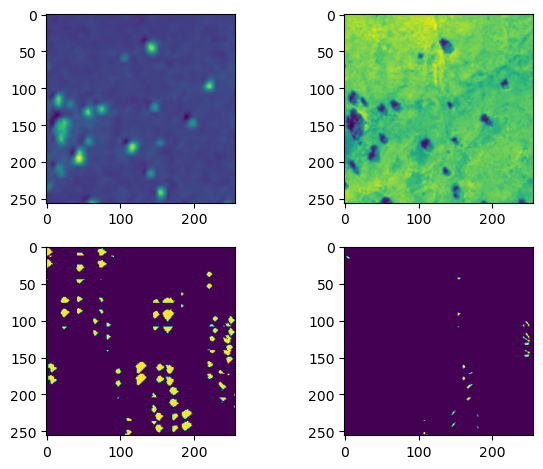

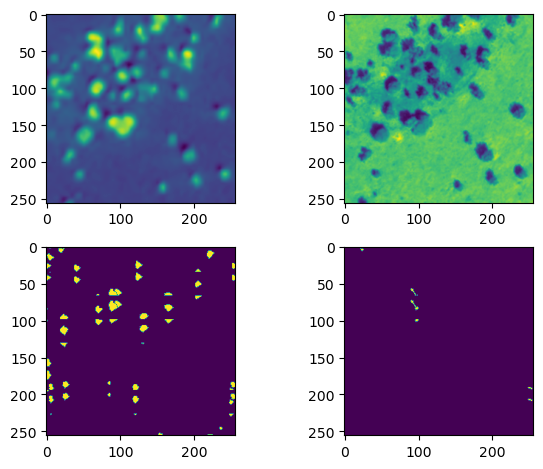

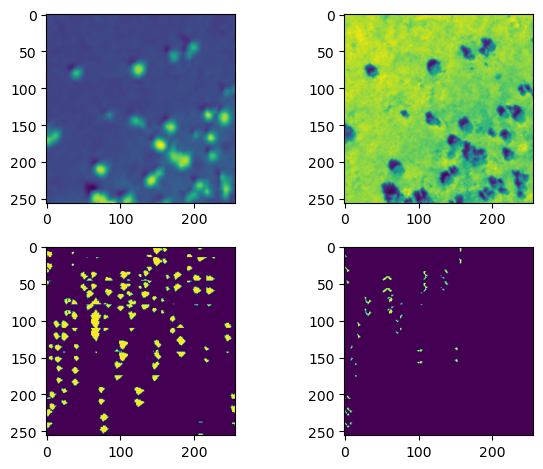

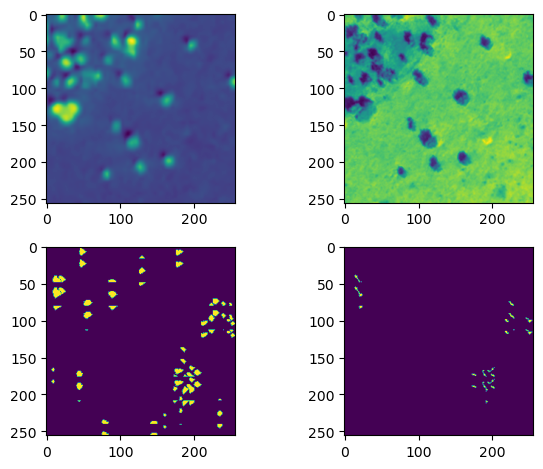

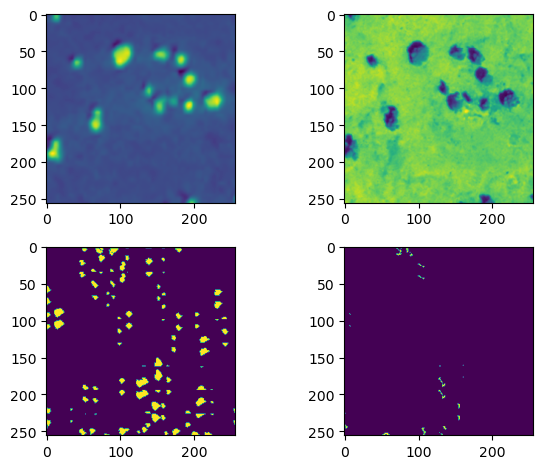

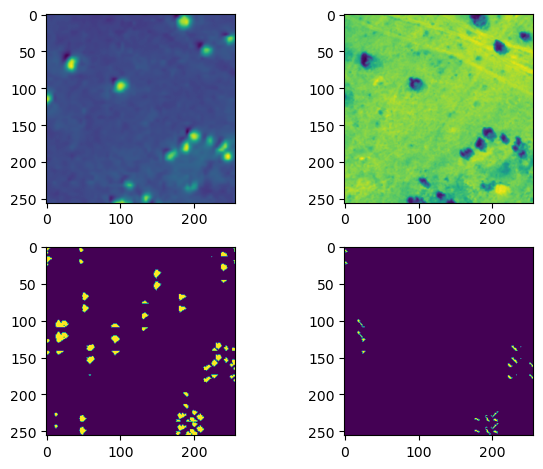

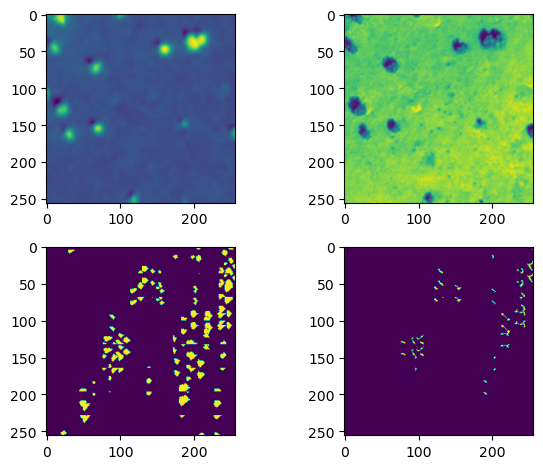

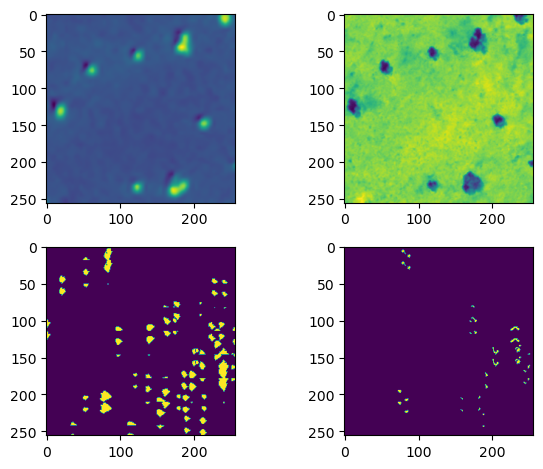

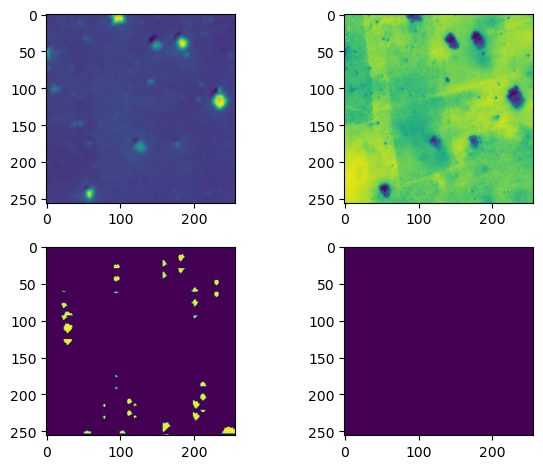

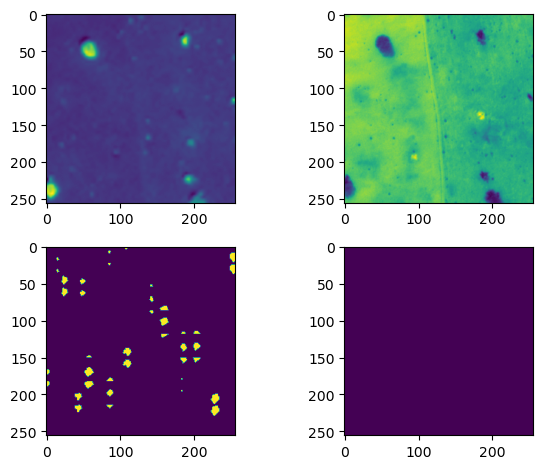

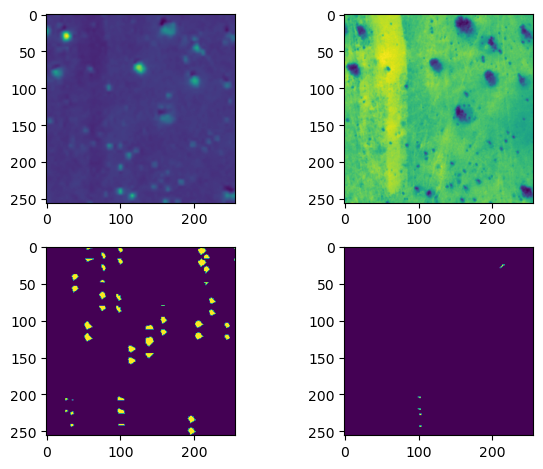

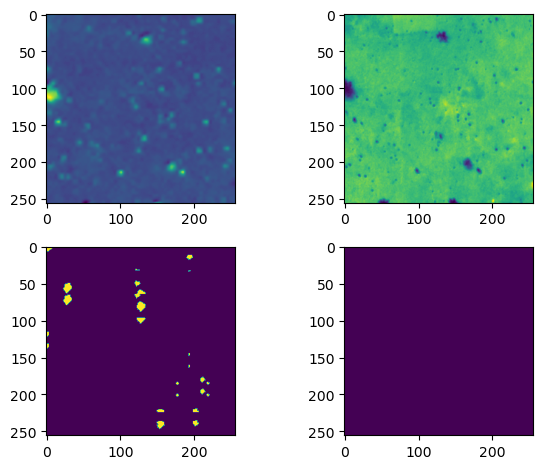

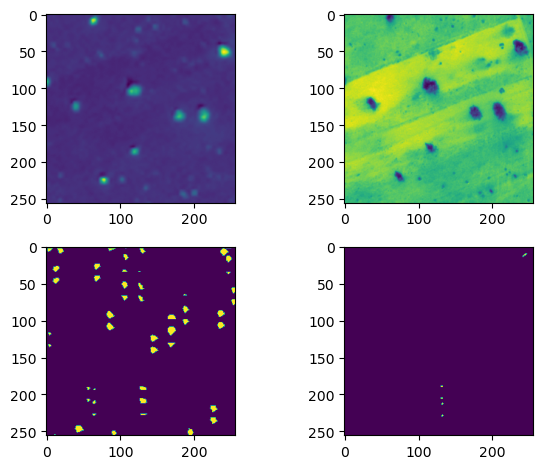

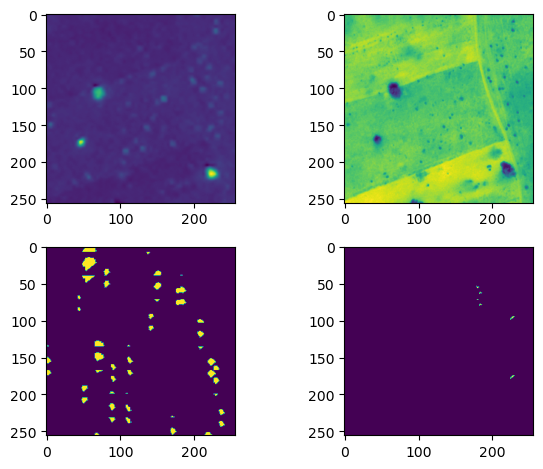

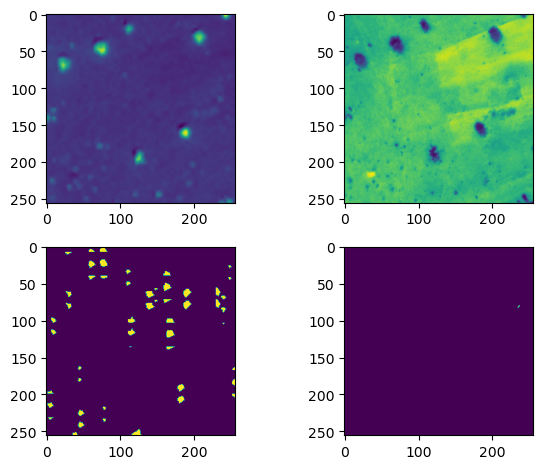

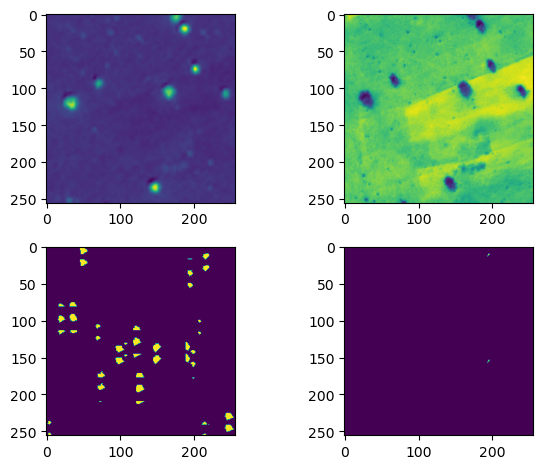

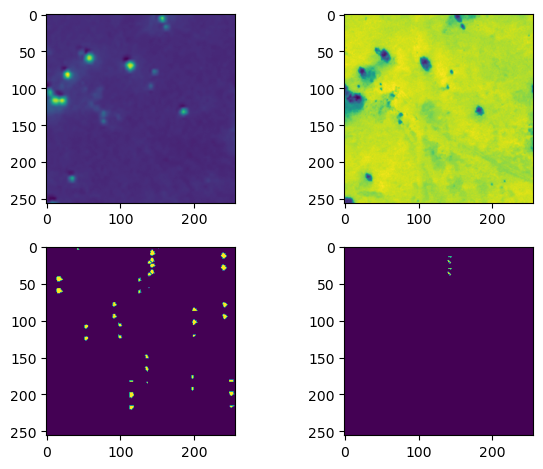

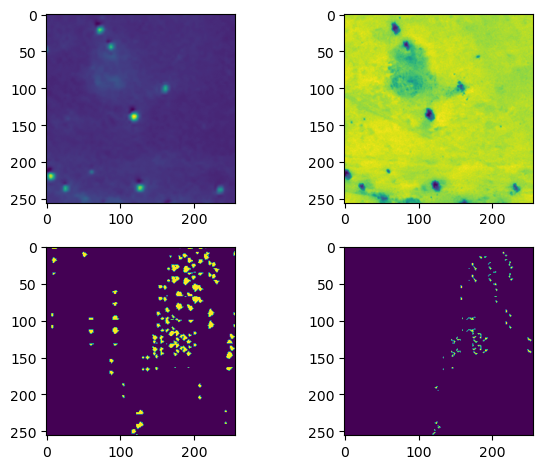

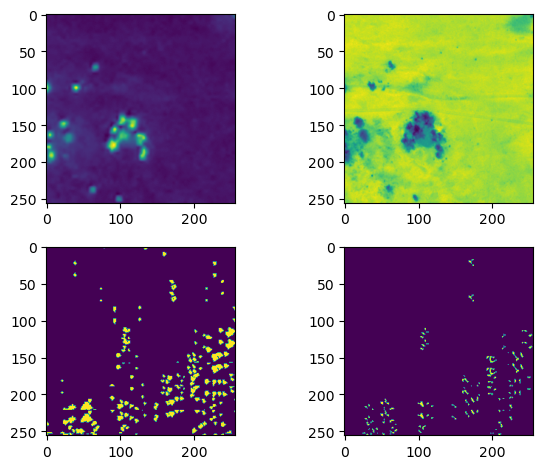

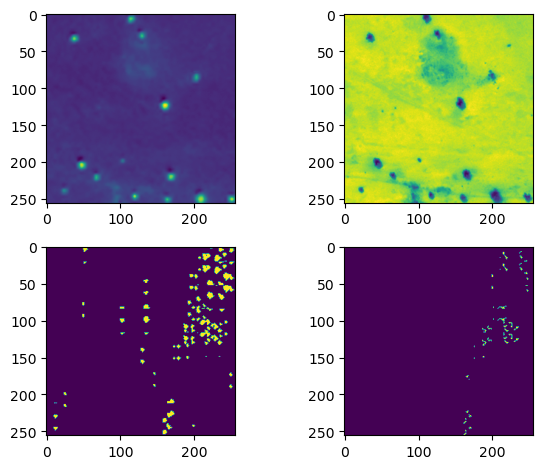

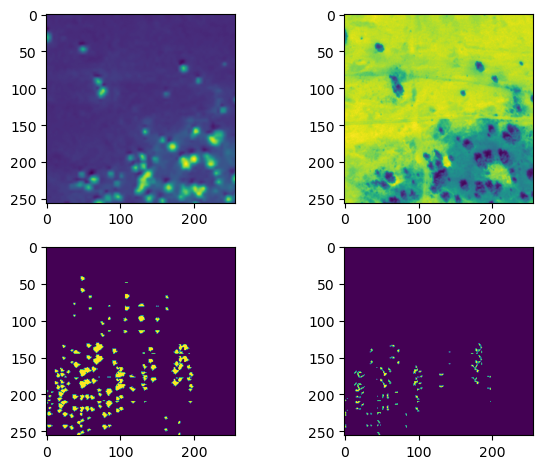

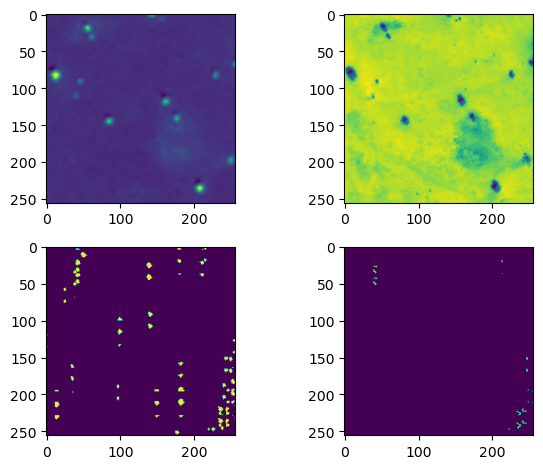

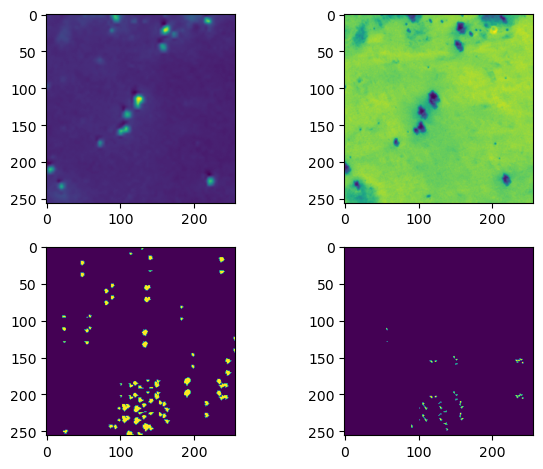

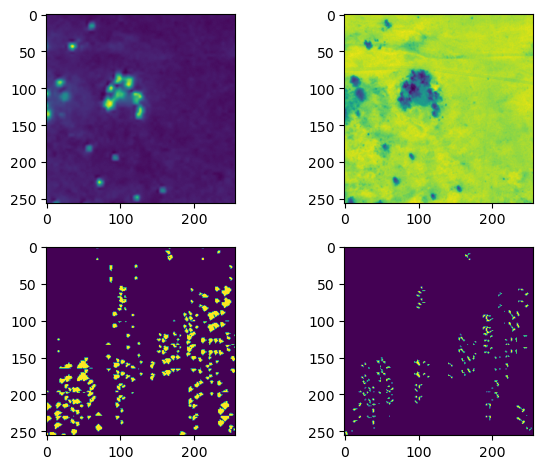

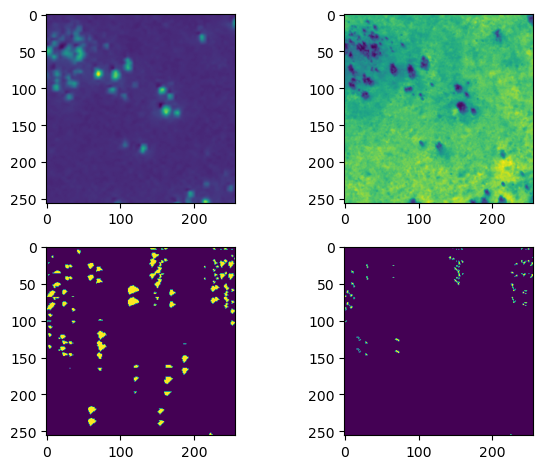

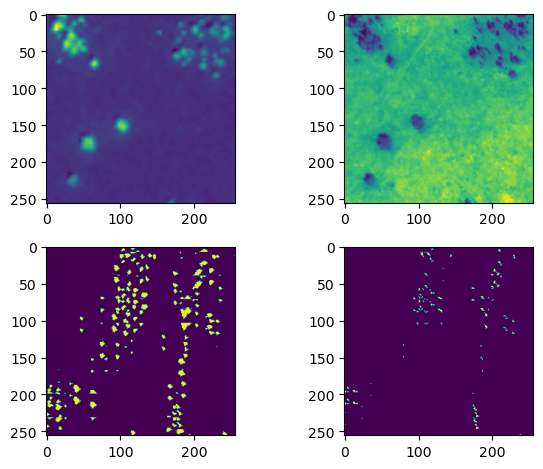

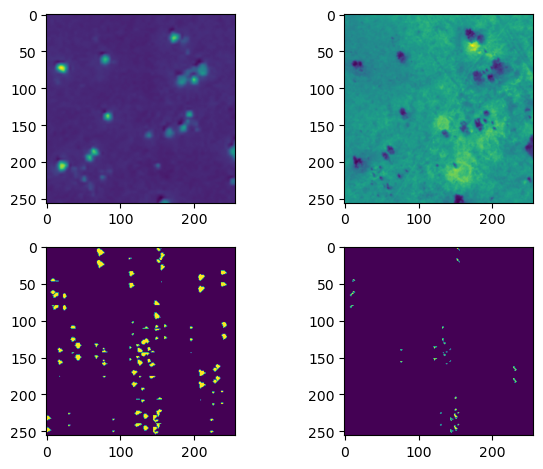

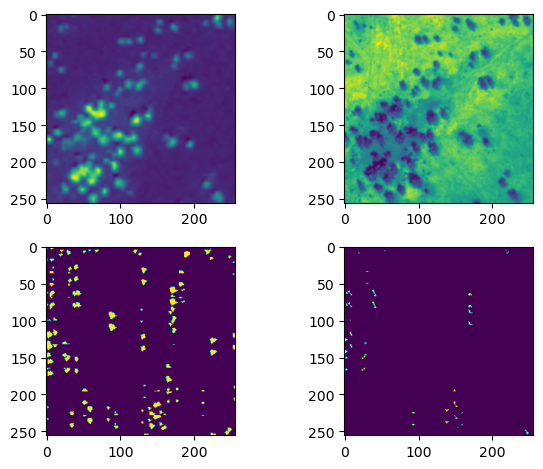

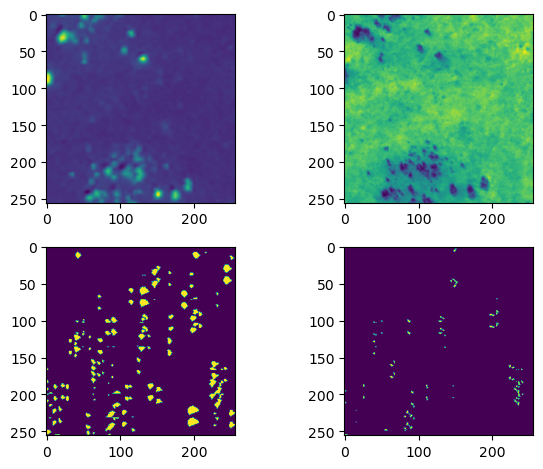

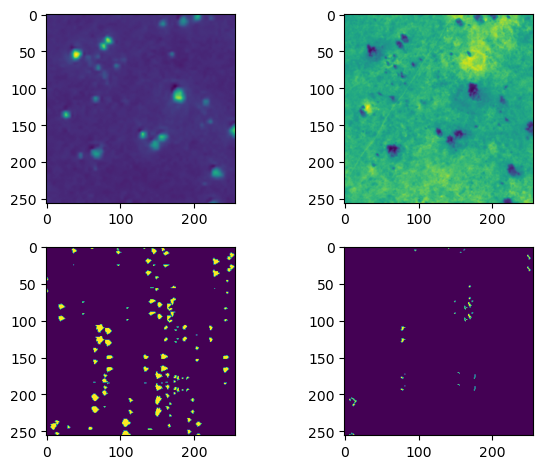

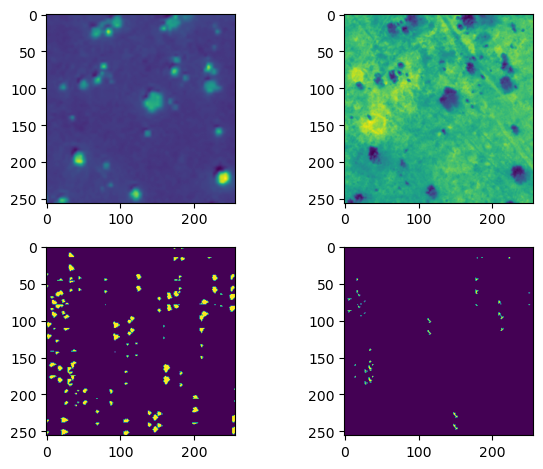

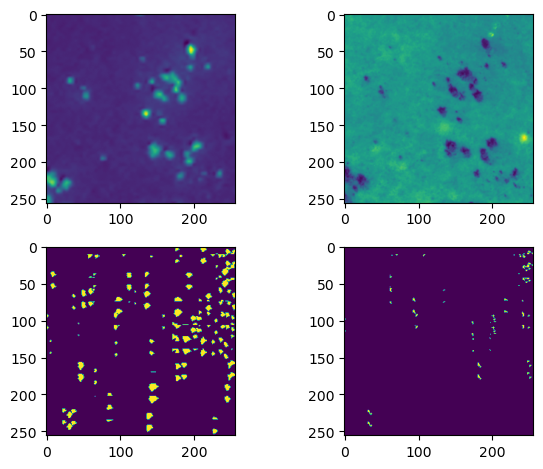

: 

In [19]:
def load_data(input_data_dir:str, num_patches:int=8): 

    '''
    
    Arguments
    ---------

    num_patches : int
        - number of 256x256 patches to randomly sample from input images. 
    
    Notes 
    -----
    This is pretty messy not going to lie. It works though. 

    '''

    from torch.utils.data import DataLoader
    import os 
    import numpy as np
    import torch
    import rasterio 
    from PIL import Image
    from PIL import ImageFile
    from sklearn.model_selection import train_test_split
    from torchvision import transforms
    from torch.utils.data import TensorDataset, DataLoader
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    annotations = [os.path.join(input_data_dir, f'extracted_annotation_{i}.png') for i in range(4)]
    boundaries = [i.replace('extracted_annotation', 'extracted_boundary') for i in annotations]
    ndvi_images = [i.replace('extracted_annotation', 'extracted_ndvi') for i in annotations]
    pan_images = [i.replace('extracted_annotation', 'extracted_pan') for i in annotations]

    #trans = transforms.Compose([transforms.ToTensor()])

    dim = rasterio.open(ndvi_images[0]).read().shape[1:]

    N = num_patches*len(ndvi_images)

    X = np.zeros(shape=(N, 2, 256, 256)) # (N, C, H, W)
    y = np.zeros(shape=(N, 1, 256, 256)) # nice! more efficient...NOTE: used to be 2*dim[-1] for this W to account for weights, but to simplify, I'm just doing annotation on output for now. issue I need to fix later. 
    loss_weight = np.zeros(shape=(N, 256, 256))

    # 1. 
    idx = 0 
    for i in range(len(ndvi_images)):

        ndvi_img = rasterio.open(ndvi_images[i])
        pan_img = rasterio.open(pan_images[i])
        read_ndvi_img = ndvi_img.read()
        read_pan_img = pan_img.read()
      
        annotation_im = Image.open(annotations[i])
        annotation = np.array(annotation_im)
        annotation[annotation<0.5] = 0
        annotation[annotation>=0.5] = 1
        
        #boundaries have a weight of 10 other parts of the image has weight 1
        weight_im = Image.open(boundaries[i])
        weight = np.array(weight_im)
        weight[weight>=0.5] = 10
        weight[weight<0.5] = 1

        # Sample 256x256 Patches
        combined_for_crop = np.zeros(shape=(4, dim[-2], dim[-1]))
        combined_for_crop[0] = read_ndvi_img 
        combined_for_crop[1] = read_pan_img 
        combined_for_crop[2] = annotation 
        combined_for_crop[3] = weight 

        cropper = transforms.RandomCrop(size=(256, 256))
        combined_for_crop = torch.Tensor(combined_for_crop)

        for _ in range(num_patches):
            cropped = cropper(combined_for_crop)
            X[idx][0] = cropped[0]
            X[idx][1] = cropped[1]
            y[idx] = cropped[2]
            loss_weight[idx] = cropped[3]
            
            idx+=1 

    # 2. Split into train / validation partitions
    test_size = 0.1
    val_size = 0.2

    X_train, X_test, y_train, y_test, loss_weight_train, loss_weight_test = train_test_split(X, y, loss_weight, test_size=test_size)
    X_train, X_val, y_train, y_val, loss_weight_train, loss_weight_val = train_test_split(X_train, y_train, loss_weight_train, test_size=val_size)

    # 3. Apply Image Augmentation to training data 

    # 4. Create data loaders
    batch_size = 1
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True) # os.cpu_count()
    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(loss_weight_train)), shuffle=True, **loader_args) # Yikes this is messy. clean later. 
    val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val), torch.Tensor(loss_weight_val)), shuffle=False, **loader_args)
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test), torch.Tensor(loss_weight_test)), shuffle=False, **loader_args)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data('/Users/yaroslav/Documents/Work/NASA/old/data/first-annotations-push/first-shadows-dataset/')

In [10]:
for i in range(5):
    for j in range(4):
        print(i*j)

0
0
0
0
0
1
2
3
0
2
4
6
0
3
6
9
0
4
8
12
